#Intro:

Following the groundwork set forth in GateCount_exploratory_fil.ipynb, I'm going to import the datasets processed from that notebook and build upon some of the intuition gained from visuals there to explore other relationships.

In [2]:
# Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

In [3]:
#call to read in gate_count with all of the processing from other notebook
gate_count=pd.read_csv('../../../data/gatecount_edit.csv')
gate_count.servicedate = pd.to_datetime(gate_count.servicedate)

#fare_count=pd.read_csv('../../../data/fare_count_edit.csv')

#weather_path = '../../../data/weather/wunderground_daily_weather.csv'

#weather = pd.read_csv(weather_path)
#weather.date = pd.to_datetime(weather.date)

gate_count.head()

,Unnamed: 0,locationid,servicedate,entries,exits,servicetime_frac,weekday,month,cold,date,rain,snow,snowfalli
0,0,1002,2014-01-01,1,0,5.25,2,1,True,2014-01-01 00:00:00,0,0,0
1,1,1002,2014-01-01,8,0,5.50,2,1,True,2014-01-01 00:00:00,0,0,0
2,2,1002,2014-01-01,6,0,5.75,2,1,True,2014-01-01 00:00:00,0,0,0
3,3,1002,2014-01-01,16,3,6.00,2,1,True,2014-01-01 00:00:00,0,0,0
4,4,1002,2014-01-01,17,9,6.25,2,1,True,2014-01-01 00:00:00,0,0,0


In [32]:
weather_path = '../../../data/weather/wunderground_daily_weather.csv'
weather = pd.read_csv(weather_path)
weather.date = pd.to_datetime(weather.date)
weather[:5]

,date,fog,hail,rain,snow,mintempi,mintempm,maxtempi,maxtempm,meantempi,...,snowfalli,snowfallm,meanwindspdi,meanwindspdm,minvisi,minvism,maxvisi,maxvism,meanvisi,meanvism
0,2014-01-01,0,0,0,0,19,-7,29,-2,24,...,0.0,0.00,9,15,10,16,10,16,10,16
1,2014-01-02,1,0,0,1,2,-17,26,-3,14,...,10.6,26.92,18,28,0,0,4,6,1,2
2,2014-01-03,1,0,0,1,2,-17,14,-10,8,...,4.5,11.43,17,27,0,0,10,16,5,8
3,2014-01-04,0,0,0,0,2,-17,27,-3,15,...,0.0,0.00,12,20,10,16,10,16,10,16
4,2014-01-05,1,0,1,0,24,-4,38,3,31,...,0.0,0.00,8,13,0,1,10,16,8,14


In [21]:
##Merge the weather data into gate_count, currently only taking binary snow/rain
temp=gate_count[['locationid','servicedate','entries','exits','servicetime_frac','weekday','month','cold']]

temp=temp.merge(weather[['date','rain','snow','snowfalli']]
                ,left_on='servicedate',right_on='date')
temp.head()

,locationid,servicedate,entries,exits,servicetime_frac,weekday,month,cold,date,rain,snow,snowfalli
0,1002,2014-01-01,1,0,5.25,2,1,True,2014-01-01,0,0,0
1,1002,2014-01-01,8,0,5.50,2,1,True,2014-01-01,0,0,0
2,1002,2014-01-01,6,0,5.75,2,1,True,2014-01-01,0,0,0
3,1002,2014-01-01,16,3,6.00,2,1,True,2014-01-01,0,0,0
4,1002,2014-01-01,17,9,6.25,2,1,True,2014-01-01,0,0,0


In [4]:
'''
Fit a linear function of snowfall on the entries for a given station.

begin/end_time: set window of interest for workday. Set to normal AM rush hour

percent: T/F to show y axis as percent of avg entry w/o snow. Otherwise, raw numbers are used and y-axis will
 suffer if this function is used to plot linear fit on multiple stations whose entries differ by large amounts
 
plot: T/F whether or not to plot

plot_type: both, line, or scatter for what to display
***
returns: parameters of line of best fit
'''

def snow_change(station_id,begin_time=6.5,end_time=9.5,percent=False,plot_type='both',plot=True):
    #get subset of station
    station_records=gate_count[gate_count['locationid']==station_id]
    
    #want to subset the dataframe to only include months in which there may be snow
    # don't want the seasonal trends of Summer, Spring, early Fall to skew my values for when there 
    # is no snow
    station_records=station_records[(station_records['month']>=10) |(station_records['month']<=3)]
    station_records=station_records[station_records['weekday']<5]
    station_records=station_records[(station_records['servicetime_frac']<=end_time) & (station_records['servicetime_frac']>=begin_time) ]
    
    if(percent):
        #get subset of snow records
        no_snow=station_records[station_records['snow']==False]
        mean_ridership=np.mean(no_snow[['servicedate','entries']].groupby('servicedate').agg(np.sum)['entries'])
        #print mean_ridership
        
    station_records=station_records[station_records['snow']==True]   
    station_grouping=station_records[['servicetime_frac','servicedate','entries','snowfalli']].groupby('servicedate')
    
    snowfall_vec=station_grouping.agg(np.median)['snowfalli']
    entries_vec=station_grouping.agg(np.sum)['entries']
    
    if(percent):
        p = np.polyfit(snowfall_vec.values,entries_vec.values*1./mean_ridership,1)
    else:
        p = np.polyfit(snowfall_vec.values,entries_vec.values,1)

    x_vals=np.linspace(0,25,len(snowfall_vec.values))
    if plot:
        if (plot_type=='scatter')| (plot_type=='both'):
            if percent:
                plt.scatter(snowfall_vec.values,entries_vec.values*1./mean_ridership,alpha=0.3,color='r')
            else:
                plt.scatter(snowfall_vec.values,entries_vec.values,alpha=0.3,color='r')
        if (plot_type=='line')| (plot_type=='both'):
            plt.plot(x_vals,p[0]*x_vals+p[1],alpha=0.75,label="station: "+str(station_id)) # A red solid line

        plt.xlabel('Inches of Snow')
        plt.ylabel('Entries')
        plt.title('Snowfall vs Entries for station: '+str(station_id))
    #for day in station_grouping:
        
    return [snowfall_vec.values,p]



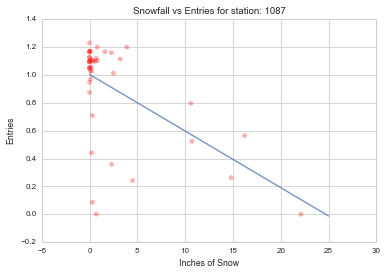

In [5]:
c=snow_change(1087,percent=True,plot_type='both')   

##Effect of Snowfall on Ridership

Exploratory analysis from GateCount_exploratory_fil.ipynb suggests that ridership gradually diminishes with increasing levels of snowfall. The following plots further investigate this claim on various classifications of station.

###Busiest stations

The busiest stations are those listed in the MBTA bluebook as having the highest weekday ridership

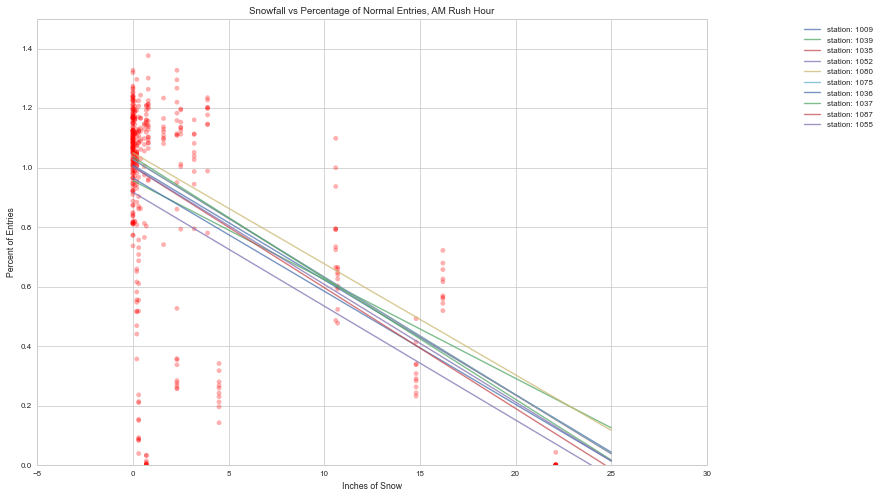

In [6]:
plt.figure(figsize=(12,8))

models=[]
for station in [1009,1039, 1035, 1052,1080,1075,1036, 1037, 1087, 1055]:
    #print station
    t=snow_change(station,percent=True,plot_type='both')
    models.append(t[1])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    #plt.title('Snowfall vs Entriesw/o Snow for station: '+str(station_id))
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()

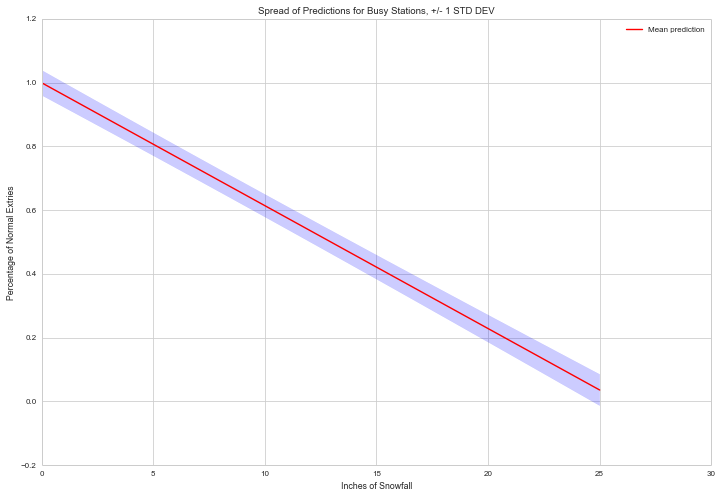

In [13]:
x_values=np.linspace(0,25,100)

pred=np.zeros([len(models),len(x_values)])
plt.figure(figsize=(12,8))

for mod in range(len(models)):
    
    pred[mod]=models[mod][0]*x_values+models[mod][1]
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.xlabel('Inches of Snowfall')
plt.ylabel('Percentage of Normal Extries')
plt.title('Spread of Predictions for Busy Stations, +/- 1 STD DEV')
plt.legend()
plt.show()



###Average ridership stations

the average stations (Kenmore, Ashmont, Hynes, JFK, Porter, Arlington, Wellington, Airport, North Quincy, Boylston)


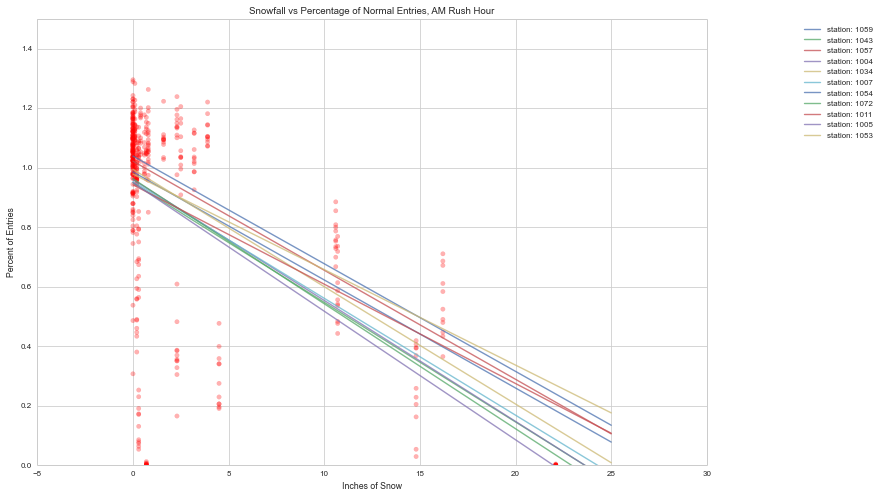

In [14]:
avg_ids=[1059, 1043, 1057, 1004, 1034, 1007,1054, 1072, 1011, 1005, 1053 ]
models=[]

plt.figure(figsize=(12,8))

for station in avg_ids:
    #print station
    t=snow_change(station,percent=True,plot_type='both')
    models.append(t[1])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    #plt.title('Snowfall vs Entriesw/o Snow for station: '+str(station_id))
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


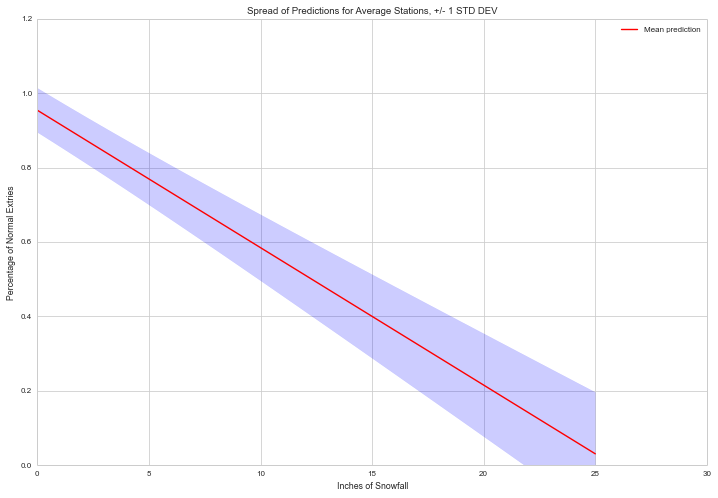

In [18]:
x_values=np.linspace(0,25,100)

pred=np.zeros([len(models),len(x_values)])
plt.figure(figsize=(12,8))

for mod in range(len(models)):
    
    pred[mod]=models[mod][0]*x_values+models[mod][1]
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.xlabel('Inches of Snowfall')
plt.ylim([0,1.2])
plt.ylabel('Percentage of Normal Extries')
plt.title('Spread of Predictions for Average Stations, +/- 1 STD DEV')
plt.legend()
plt.show()



###Low-ridership stations
the less-utilized stations (Orient Heights, Wood Island, Savin Hill, Shawmut, Riverside, Symphony, WTC, Bowdoin, Courthouse, Suffolk Downs, Science Park)


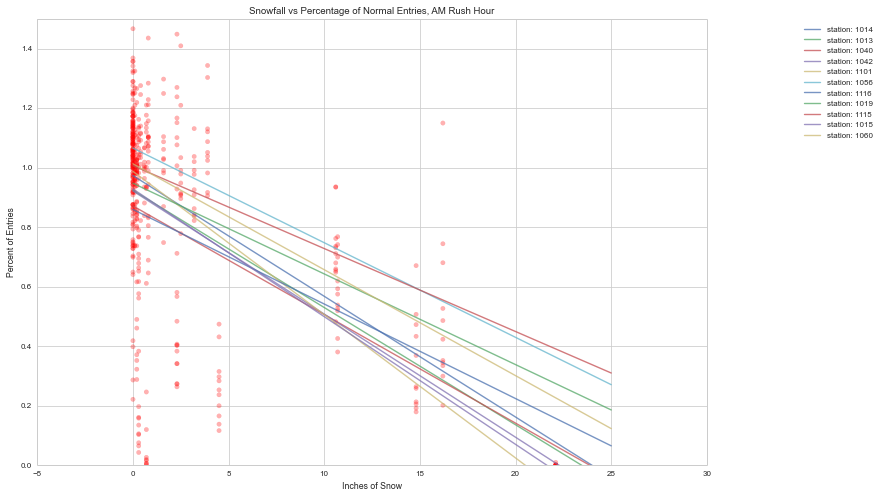

In [16]:

slow_ids=[1014, 1013, 1040, 1042, 1101, 1056, 1116, 1019, 1115, 1015, 1060]
models=[]
plt.figure(figsize=(12,8))

for station in slow_ids:
    #print station
    t=snow_change(station,percent=True,plot_type='both')
    models.append(t[1])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    #plt.title('Snowfall vs Entriesw/o Snow for station: '+str(station_id))
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


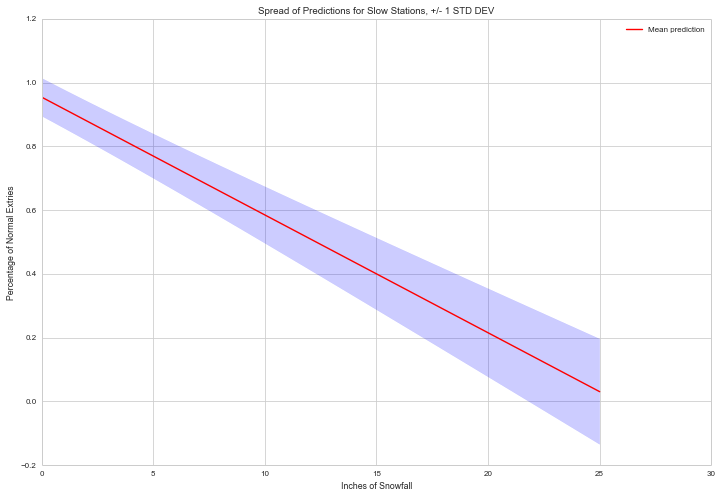

In [17]:
x_values=np.linspace(0,25,100)

pred=np.zeros([len(models),len(x_values)])
plt.figure(figsize=(12,8))

for mod in range(len(models)):
    
    pred[mod]=models[mod][0]*x_values+models[mod][1]
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.xlabel('Inches of Snowfall')
plt.ylabel('Percentage of Normal Extries')
plt.title('Spread of Predictions for Slow Stations, +/- 1 STD DEV')
plt.legend()
plt.show()



[array([ 10.6,   4.5,   0.2,   3.9,   0.3,   0. ,   1.6,  10.7,   0. ,
          0.1,   3.2,   0.1,   2.5,   0. ,   0.4,   0.1,   0.6,   0. ,
          0. ,   0. ,   0. ,   0. ,   0.3,   2.3,   0. ,   0.3,   0. ,
          0. ,   0.2,   0. ,   0.2,   0. ,   0.8,   0. ,   2.3,  22.1,
          0.2,   0.7,  16.2,   0. ,   0.8,  14.8,   0.7]),
 array([-0.0385684 ,  1.00801026])]

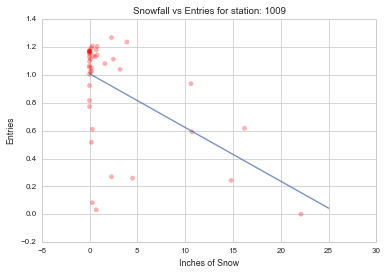

In [228]:
snow_change(1009,percent=True,plot_type='both')

In [7]:
def get_point_response(station_id_vec,begin_time=6.5,end_time=9.5,percent=False,plot_type='both',plot=True):
    #get subset of stations
    df_list=[]
    for stat_id in station_id_vec:
        df_list.append(gate_count[gate_count['locationid']==stat_id])
        
    station_records=pd.concat(df_list)
    
    #want to subset the dataframe to only include months in which there may be snow
    # don't want the seasonal trends of Summer, Spring, early Fall to skew my values for when there 
    # is no snow
    station_records=station_records[(station_records['month']>=10) |(station_records['month']<=3)]
    station_records=station_records[station_records['weekday']<5]
    station_records=station_records[(station_records['servicetime_frac']<=end_time) & (station_records['servicetime_frac']>=begin_time) ]
    
    #initialize in case percent==False
    mean_no_snow=1;
    if(percent):
        #get subset of snow records
        no_snow=station_records[station_records['snow']==False]
        g=no_snow[['locationid','servicedate','entries']].groupby(['locationid','servicedate']).agg(np.sum).reset_index()
        mean_no_snow=np.mean(g.groupby('servicedate').agg(np.mean)['entries'])
        
        
    station_records=station_records[station_records['snow']==True]   
    
    # Return the sum of entries by station by day and the snowfall for that day
    temp=station_records[['locationid','servicedate','entries','snowfalli']].groupby(['locationid','servicedate']).agg({'entries':np.sum,'snowfalli':np.median})

    #want to bring everything into context of entries compared to average for no snow
    # need custom function for computing the variance. Divide the computed mean across all stations
    # for that day by the avg ridership across all stations on days without snow
    def temp_mean(x):
        return np.mean(x*1./mean_no_snow)
    def temp_var(x):
        return np.var(x*1./mean_no_snow)
    # Compute the mean ridership as a percentage of normal and var of percentages
    temp=temp.groupby('snowfalli').agg([temp_mean,temp_var])
    
    return [temp.index,temp['entries']['temp_mean'].values,temp['entries']['temp_var'].values]
    
c=get_point_response([1009,1087],percent=True)



In [8]:
c=get_point_response([1009],percent=True)


In [11]:
from sklearn.gaussian_process import GaussianProcess


In [28]:
#removing the datapoint with 22 inchese of snow as the model is very sensitive to it
# yet it is very uncharacteristic
snowfall=np.atleast_2d(c[0][:-1]).T
ridership=c[1][:-1]
variance=c[2][:-1]


[[ 1.]]


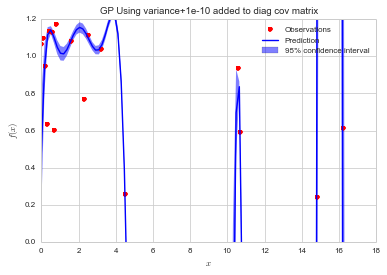

In [45]:

space = np.atleast_2d(np.linspace(0, 17, 100)).T

# Instantiate a Gaussian Process model
'''gp = GaussianProcess(regr='linear', theta0=1, thetaL=1e-5, thetaU=20,
                     random_start=100,nugget=1e-10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(snowfall, ridership)

print gp.theta_

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(space, eval_MSE=True)
sigma = np.sqrt(MSE)

fig = plt.figure(1, figsize=(8,5))
plt.subplot(121)
plt.plot(snowfall, ridership, 'r.', markersize=10, label=u'Observations')
plt.plot(space, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([space, space[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0,1.2)
plt.legend(loc='upper right')
plt.title('GP Using 1e-10 added to diag cov matrix')
'''


##fit with variance of model+little additional to help deal with those points where variance==0
# Instantiate a Gaussian Process model
gp2 = GaussianProcess(regr='linear', theta0=1e-10, thetaL=1e-20, thetaU=1,
                     random_start=200,nugget=variance+1e-10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp2.fit(snowfall, ridership)

print gp2.theta_

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp2.predict(space, eval_MSE=True)
sigma = np.sqrt(MSE)

#plt.subplot(122)
plt.plot(snowfall, ridership, 'r.', markersize=10, label=u'Observations')
plt.plot(space, y_pred, 'b-', label=u'Prediction')
#plt.errorbar(snowfall,ridership,variance,fmt='none')
plt.fill(np.concatenate([space, space[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0,1.2)
plt.legend(loc='upper right')
plt.title('GP Using variance+1e-10 added to diag cov matrix')
plt.show()

In [ ]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess( theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.plot(X, y, 'r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

##Gaussian Processes

In [23]:
from pymc.gp import *
from pymc.gp.cov_funs import matern


(-1.0, 0.99000000000000177, 2.4854009793906218, 3.9624679844736916)

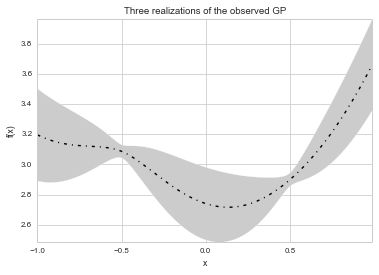

In [29]:
def quadfun(x, a, b, c):
    return (a * x ** 2 + b * x + c)

M = Mean(quadfun, a=1., b=.5, c=2.)
C = Covariance(
    eval_fun=matern.euclidean,
    diff_degree=1.4,
    amp=.4,
    scale=1.)

o = np.array([-.5, .5])
V = np.array([.002, .002])
data = np.array([3.1, 2.9])
observe(M, C, obs_mesh=o, obs_V=V, obs_vals=data)

# Generate realizations
f_list = [Realization(M, C) for i in range(3)]

x = np.arange(-1., 1., .01)

plot_envelope(M, C, mesh=x)

'''for f in f_list:
    plot(x, f(x))'''

xlabel('x')
ylabel('f(x)')
title('Three realizations of the observed GP')
axis('tight')